In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
import glob
from itertools import chain
%matplotlib inline


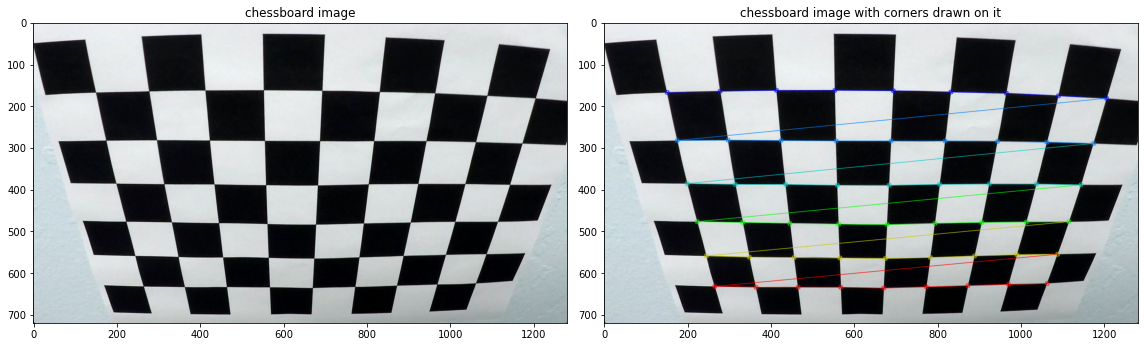

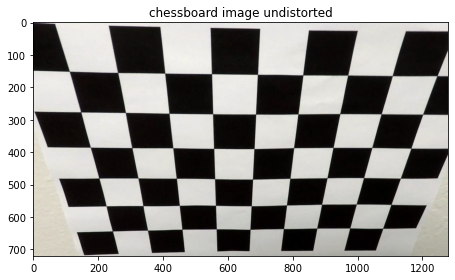

In [2]:
################# STEP 1: Camera Calibration #################

# Number of object points
nx = 9
ny = 6

# Termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

# Load chessboard images to use for calibrating the camera
images = glob.glob(r'camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # Add object points, reinfine and add image points
    if ret == True:
        objpoints.append(objp)

        # Increase accuracy
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        #print a sample picture
        if fname == 'camera_cal/calibration2.jpg':
            f, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
            ax1.set_title('chessboard image')
            ax1.imshow(img)
            cv2.drawChessboardCorners(img, (nx,ny), corners2, ret)
            ax2.set_title('chessboard image with corners drawn on it')
            ax2.imshow(img)
            plt.tight_layout()

# Get camera matrix, distortion coefficients, rotation and translation vectors
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Save parameters from camera calibration for future use
np.savez('camera_cal/camera_cal_parameters.npz', ret=ret, mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

chessboard = mpimg.imread("camera_cal/calibration2.jpg")
f, ax = plt.subplots(1,1,figsize=(8,4))
chessbrd_undist = cv2.undistort(chessboard, mtx, dist, None, mtx)
ax.set_title('chessboard image undistorted') 
ax.imshow(chessbrd_undist)
plt.tight_layout()


dst: [[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]
src: [[ 579.       460.     ]
 [ 193.33333  720.     ]
 [1126.6666   720.     ]
 [ 703.       460.     ]]


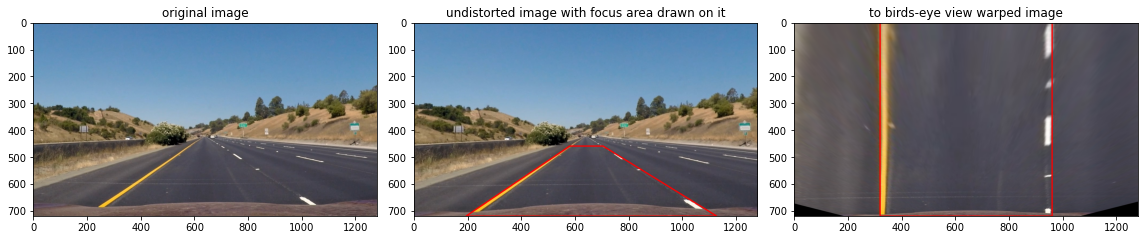

In [3]:
################# STEP 2: Perspective Transform, warp undistorted images to birds-eye-view #################

# Load a straight lane line image
image = mpimg.imread("test_images/straight_lines1.jpg")

# Grab the image shape
img_size = (image.shape[1], image.shape[0])

# Set source and destination points manually
src = np.array([[(img_size[0] / 2 - 61),    (img_size[1] / 2 + 100)], # left / upper
                [(img_size[0] / 6 - 20),     img_size[1]],            # left / lower 
                [(img_size[0] * 5 / 6 + 60), img_size[1]],            # right / lower
                [(img_size[0] / 2 + 63),    (img_size[1] / 2 + 100)]], np.float32) # right / upper

dst = np.array([[(img_size[0] / 4),     0],
                [(img_size[0] / 4),     img_size[1]],
                [(img_size[0] * 3 / 4), img_size[1]],
                [(img_size[0] * 3 / 4), 0]], np.float32)

print(f'dst: {dst}')
print(f'src: {src}')

# Load Camera Calibration data
cam_callibration = np.load('camera_cal/camera_cal_parameters.npz') #print(cam_callibration.files)
mtx = cam_callibration['mtx']
dist = cam_callibration['dist']

# Remove distortion
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp image
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
warped_image = np.copy(warped) # copy for visualizing the detected lane line pixels

# Draw lines on images
src_pts = src.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(undist, [src_pts], isClosed=True, color=(255, 0, 0), thickness=3)

dst_pts = dst.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(warped, [dst_pts], isClosed=True, color=(255, 0, 0), thickness=3)

# Plot images
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,8))
ax1.set_title('original image')
ax1.imshow(image)
ax2.set_title('undistorted image with focus area drawn on it')
ax2.imshow(undist)
ax3.set_title('to birds-eye view warped image')
ax3.imshow(warped)
plt.tight_layout()
#f.savefig(f'examples/perspective_transform.png')

In [4]:
################# STEP 3: Lane line detection #################

def combined_lane_line_detection(warped_image):
    """Returns a binary with pixels belonging to the lane line"""
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,8))
    warped_img = cv2.morphologyEx(warped_image, cv2.MORPH_CLOSE, kernel)
    
    # Convert to HLS color space and separate the S  and L channel
    hls = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # Grayscale image
    gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 110
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    l_thresh_min = 210
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    color_binary = np.dstack((l_binary, sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |
                    (l_binary == 1) |
                    (sxbinary == 1)] = 1
    
    # Delete pixels at the edges of the image
    combined_binary[:,:150]  = 0
    combined_binary[:,1130:] = 0
    
    return color_binary, combined_binary

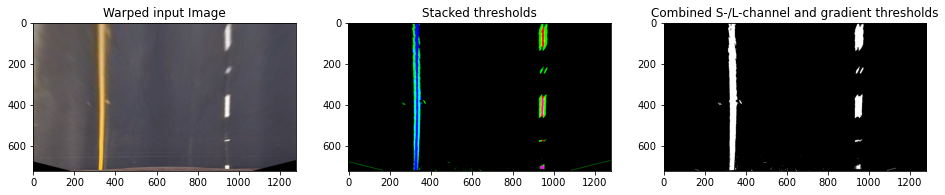

In [5]:
color_binary, combined_binary = combined_lane_line_detection(warped_image)

# Plotting thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,8))
ax1.set_title('Warped input Image')
ax1.imshow(warped_image)
ax2.set_title('Stacked thresholds')
ax2.imshow(color_binary)
ax3.set_title('Combined S-/L-channel and gradient thresholds')
ax3.imshow(combined_binary, cmap='gray')
#f.savefig(f'examples/lane_line_pixels.png')

In [6]:
def warp_image(image, mtx, dist, src, dst):
    """Returns an undistorted and to birsd-eye view warped image."""    
    # Grab the image shape
    img_size = (image.shape[1], image.shape[0])
    # Remove distortion
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp and return the image
    return cv2.warpPerspective(undist, M, img_size)

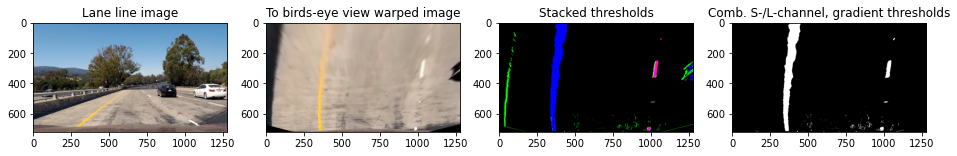

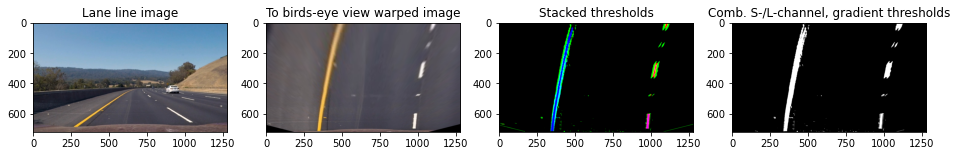

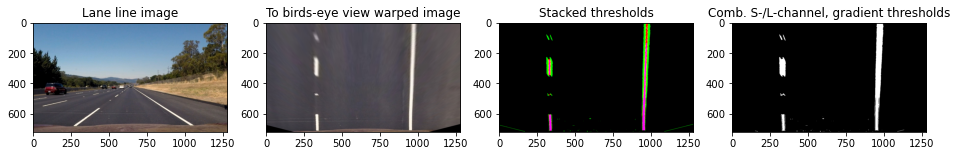

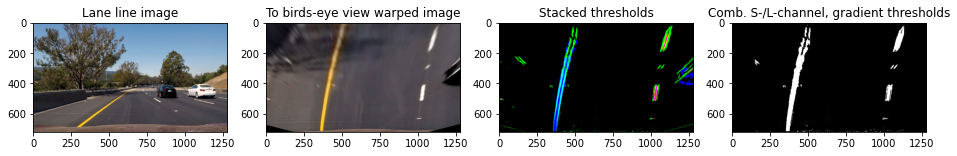

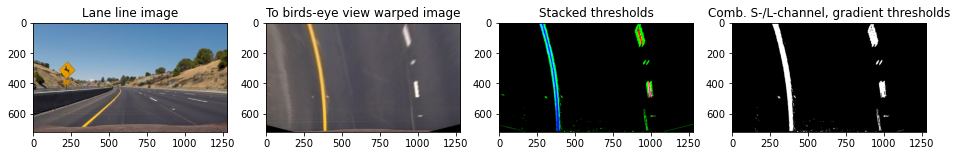

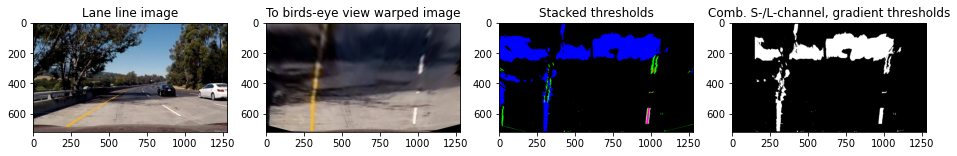

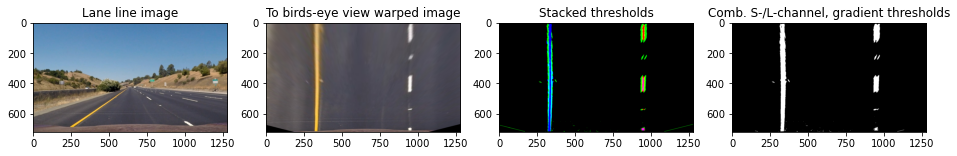

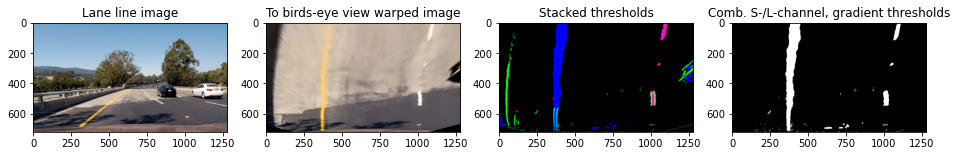

In [7]:
## Load all test images and adjust the thresholds for the lane line detection:

test_images = glob.glob(r'test_images/*.jpg')

for test_img in test_images:
    # name for saving the plot
    save_name = r'examples/sample_' + test_img.split('/')[1]
    # Load image
    test_img = mpimg.imread(test_img)
    # Warp image
    test_img_warped = warp_image(test_img, mtx, dist, src, dst)
    color_binary, combined_binary = combined_lane_line_detection(test_img_warped)
    # Plot images
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,8))
    ax1.set_title('Lane line image')
    ax1.imshow(test_img)
    ax2.set_title('To birds-eye view warped image')
    ax2.imshow(test_img_warped)
    ax3.set_title('Stacked thresholds')
    ax3.imshow(color_binary)
    ax4.set_title('Comb. S-/L-channel, gradient thresholds')
    ax4.imshow(combined_binary, cmap='gray')
    #f.savefig(save_name)

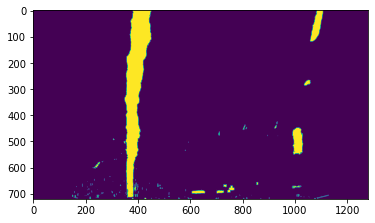

In [8]:
################# STEP 4: Find lane lines and fit a polynomial for measuring the curvature #################

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
plt.imshow(combined_binary)

In [9]:
def fit_poly_with_windows(binary_warped):
    """
    Returns a polynomial for the left and right lane line
    based on left and right line pixel positions found by using the windows search method
    """
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram -> starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 250

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit_m, right_fit_m, left_fit, right_fit, ploty


In [10]:
def fit_poly_around_last_poly(binary_warped,left_fit,right_fit):
    """
    Returns a polynomial for the left and right lane line
    based on the last detected polynomials
    """
    
    # Width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, left_fit_m, right_fit_m, left_fit, right_fit, ploty, nonzero


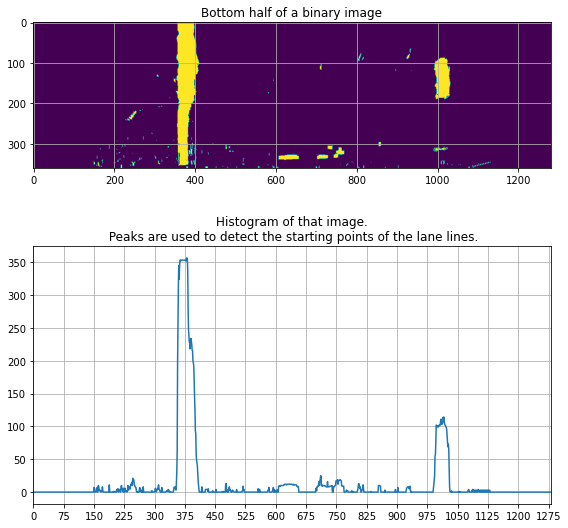

In [11]:
# Histogram of the bottom half of the image as the starting points for the left and right line detection.

bottom_half_img = combined_binary[combined_binary.shape[0]//2:,:]
histogram = np.sum(bottom_half_img, axis=0)
tick_spacing = 75
f,(ax1,ax2)=plt.subplots(2,1,figsize=(8,8))
ax1.set_title('Bottom half of a binary image')
ax2.set_xlim([0, 1280])
ax1.imshow(bottom_half_img)
ax1.grid()
ax2.set_title('Histogram of that image.\n Peaks are used to detect the starting points of the lane lines.')
ax2.set_xlim([0, 1280])
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.grid()
ax2.plot(histogram)
f.tight_layout() 
#f.savefig('./examples/histogram')

left_fit_m: [ 3.82666019e-04 -1.92038342e-02  2.21717734e+00],
right_fit_m: [ 1.07517618e-03 -4.59334636e-02  5.83350145e+00],
left_fit: [ 1.25687975e-04 -1.51381576e-01  4.19465984e+02],
right_fit: [ 3.53145331e-04 -3.62088114e-01  1.10363541e+03]


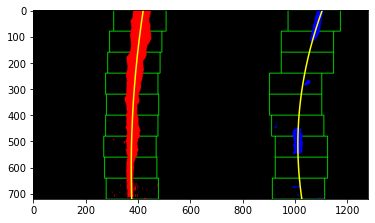

In [12]:
## Sample picture of the detected lane lines with sliding windows method
out_img, left_fitx, right_fitx, left_fit_m, right_fit_m, left_fit, right_fit, ploty = fit_poly_with_windows(combined_binary)
plt.imshow(out_img)

print(f'left_fit_m: {left_fit_m},''\n'
      f'right_fit_m: {right_fit_m},''\n'
      f'left_fit: {left_fit},''\n'
      f'right_fit: {right_fit}')
#plt.savefig('./examples/sliding_windows')

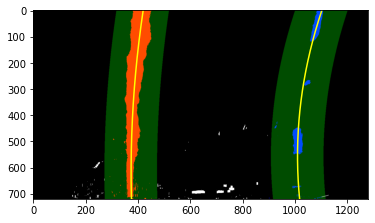

In [13]:
## Sample picture of the detected lane lines with search around last detection method
left_fit = np.array([1.18055509e-04, -1.47095622e-01,  4.18833617e+02])
right_fit = np.array([1.78084594e-04, -2.62219520e-01,  1.09810872e+03])

out_img, left_fitx, right_fitx, left_fit_m, right_fit_m, left_fit, right_fit, ploty, nonzero = fit_poly_around_last_poly(combined_binary,left_fit,right_fit)
plt.imshow(out_img)

#plt.savefig('./examples/search_around_poly')

In [14]:
################# STEP 5: Calculate the radius of curvature in meters for both lane lines #################

def measure_curvature(left_fit_m, right_fit_m, image):
    """Calculates the curvature of polynomial functions in meters"""
        
    # Define y-value where we want radius of curvature: bottom of the image
    y_eval = image.shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    
    return left_curverad, right_curverad

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature(left_fit_m, right_fit_m, out_img)

print(f'Left line Curvature: {left_curverad:8.2f} m''\n'
      f'Right line Curvature: {right_curverad:7.2f} m')

Left line Curvature:  1357.88 m
Right line Curvature:  548.28 m


In [15]:
def car_position(left_fit_m, right_fit_m, image):
    
    heigth = image.shape[0] * ym_per_pix
    width  = image.shape[1] * xm_per_pix

    left_m  = left_fit_m[0] * heigth**2 + left_fit_m[1] * heigth + left_fit_m[2]
    right_m = right_fit_m[0]* heigth**2 + right_fit_m[1]* heigth + right_fit_m[2]    
    
    position = (left_m + right_m) /2
        
    return position

position = car_position(left_fit_m, right_fit_m, out_img)

print(f'Postion of the car: {position:2.2f} m')
print(f'mid of road: {640*xm_per_pix:11.2f} m')


Postion of the car: 3.68 m
mid of road:        3.38 m


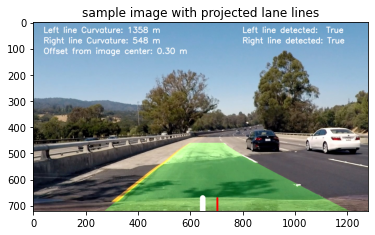

In [16]:
################# STEP 6: Draw lane lines area and informations about curvature #################

def project_lane_lines(img,combined_binary,left_fitx,right_fitx,dst,src,left_curverad,right_curverad,position,left_line_detected,right_line_detected):
    """Returns a projection of the measurement back down onto the road"""
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8) 
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Calculate the inverse perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Calculate the cars offset to the midth of the lane
    height = img.shape[0]
    width  = img.shape[1]
    #offset_pix = abs(position/xm_per_pix) - width
    offset_m = (position - width*xm_per_pix/2)
    

    # Add Information for curvature and Offset to the output image
    cv2.putText(out_img,f'Left line Curvature: {left_curverad:4.0f} m',   (40,40), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Right line Curvature: {right_curverad:2.0f} m', (40,80), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Offset from image center: {offset_m:3.2f} m',     (40,120),cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img, '|', (int(width/2),height), cv2.FONT_ITALIC, 2., (255,255,255),20,cv2.LINE_AA)
    cv2.putText(out_img, '|', (int(position/xm_per_pix) ,height), cv2.FONT_ITALIC, 2., (255,0,0),5,cv2.LINE_AA)
    cv2.putText(out_img,f'Left line detected:  {left_line_detected}', (800,40), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Right line detected: {right_line_detected}',   (800,80), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    return out_img


# Load a straight lane line image
img = mpimg.imread("./test_images/test4.jpg")

left_line_detected = True
right_line_detected = True
result_image = project_lane_lines(img,
                                  combined_binary,
                                  left_fitx,
                                  right_fitx,
                                  dst,
                                  src,
                                  left_curverad,
                                  right_curverad,
                                  position,
                                  left_line_detected,
                                  right_line_detected)
plt.title('sample image with projected lane lines')
plt.imshow(result_image)
#plt.savefig('./examples/projected_lane_lines.png')

In [17]:
################# STEP 7: Implement a Class for tracking each lane line #################

In [18]:
class Line():
    """For tracking the characteristics of each line detection"""
    
    ##### Constant values
    N = 5 # number of frames for smoothing curvature and line fits
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    def __init__(self):
        ##### values for detected line pixel values
        self.allx = None                 # x values
        self.ally = None                 # y values
        self.recent_xfitted = []         # x values of the last n fits of the line
        self.recent_yfitted = []         # y values of the last n fits of the line
        self.bestx = [np.array([False])] # average x values of the fitted line over the last N iterations
        self.besty = [np.array([False])] # average y values of the fitted line over the last N iterations
        ##### Polynomial coefficeints (pc) in pixel
        self.current_fit = [np.array([False])]  # for the most recent fit
        self.recent_polyfitted = []             # of the last N fits of the line
        self.best_fit = None                    # averaged over the last N iterations
        ##### Polynomial coefficeints (pc) in meter
        self.current_fit_m = [np.array([False])] # for the most recent fit 
        self.recent_polyfitted_m = []            # of the last N fits of the line
        self.best_fit_m = None                   # averaged over the last N iterations
        ##### Radius of curvature of the line
        self.radius_of_curvature = None # in meter
        self.recent_rad_of_curv = []    # of the last N fits
        self.best_rad_of_curv = None    # averaged over the last N iterations
        ##### Distance in meters of vehicle center from the line
        self.line_base_pos = None      # in meter
        self.recent_line_base_pos = [] # the last N
        self.best_line_base_pos = None # averaged over the last N values
        ##### Difference in polynomial fit between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        self.recent_diffs = []
        self.best_diffs = None
        ##### Misc
        self.detected = False # was the line detected in the last iteration?
        self.line_check = True     # are the line checks ok?
        self.frame_count = 0  # count frames for images without lane line detection
        self.image_size = (None, None) # image size in pixel (y, x)
    
    def set_line_base_pos(self):
        camera_offset_from_midth = 0#0.30
        heigth_m = self.image_size[0] * self.ym_per_pix
        width_m  = self.image_size[1] * self.xm_per_pix
        fit_m    = self.current_fit_m
        lane_m   = abs(fit_m[0] * heigth_m**2 + fit_m[1] * heigth_m + fit_m[2])
        self.line_base_pos = (lane_m - (width_m/2 + camera_offset_from_midth))
        self.recent_line_base_pos.append(self.line_base_pos)
        self.recent_line_base_pos = self.recent_line_base_pos[-self.N:]
        self.best_line_base_pos = np.mean(np.array(self.recent_line_base_pos), axis=0)
        
    def set_allx(self, lanex):
        self.allx = lanex
        self.recent_xfitted.append(self.allx)
        self.recent_xfitted = self.recent_xfitted[-self.N:]
        self.bestx = np.array(list(chain.from_iterable(self.recent_xfitted))).astype(int)
        
    def set_ally(self, laney):
        self.ally = laney
        self.recent_yfitted.append(self.ally)
        self.recent_yfitted = self.recent_yfitted[-self.N:]
        self.besty = np.array(list(chain.from_iterable(self.recent_yfitted))).astype(int)
        
    def set_detected(self, bool_value):
        self.detected = bool_value
    
    def set_line_check(self, bool_value):
        self.line_check = bool_value
        
    def set_image_size(self, image):
        self.image_size = (image.shape[0], image.shape[1])
    
    def add_to_frame_count(self):
        self.frame_count += 1
    
    def reset_frame_count(self):
        self.frame_count = 0
    
    def fit_polynomial(self):
        """Fit a second order polynomial"""
        self.current_fit = np.polyfit(self.besty, self.bestx, 2)
        self.diffs = self.current_fit
        self.recent_polyfitted.append(self.current_fit)
        self.recent_polyfitted = self.recent_polyfitted[-self.N:]
        self.best_fit = np.mean(np.array(self.recent_polyfitted), axis=0)
        
        self.current_fit_m = np.polyfit(self.besty*self.ym_per_pix, self.bestx*self.xm_per_pix, 2)
        self.recent_polyfitted_m.append(self.current_fit_m)
        self.recent_polyfitted_m = self.recent_polyfitted_m[-self.N:]
        self.best_fit_m = np.mean(np.array(self.recent_polyfitted_m), axis=0)
    
    def measure_curvature(self):
        """Calculate the radius of the curvature in meters"""
        y_eval = self.image_size[0]
        fit_m  = self.current_fit_m
        self.radius_of_curvature = ((1+(2*fit_m[0]*y_eval*self.ym_per_pix+fit_m[1])**2)**1.5) / np.absolute(2*fit_m[0])
        self.recent_rad_of_curv.append(self.radius_of_curvature)
        self.recent_rad_of_curv  = self.recent_rad_of_curv[-200:]
        self.best_rad_of_curv    = sum(self.recent_rad_of_curv) / len(self.recent_rad_of_curv)
        
    def check_offset_from_base_pos(self):
        ### this method is not used, but a proposal for further improvement
        if not (abs(self.line_base_pos)*0.8 < abs(self.line_base_pos) < abs(self.line_base_pos)*1.2):
            self.line_check = False
            
    def check_curvature(self):
        ### this method is not used, but a proposal for further improvement
        if not (self.radius_of_curvature*0.5 < abs(self.best_rad_of_curv) < self.radius_of_curvature*1.5):
            self.line_check = False     
        
        
    def check_polynomial_diffs(self):
        ### this method is not used, but a proposal for further improvement
        try:
            self.diffs = self.current_fit / self.recent_polyfitted[-2]
        except:
            self.diffs = np.array([1.,1.,1.], dtype='float')
        self.recent_diffs.append(self.diffs)
        self.recent_diffs = self.recent_diffs[-self.N:]
        self.curv_700 = (self.current_fit_m[0]*(700/ym_per_pix)**2 +
                         self.current_fit_m[1]*(700/ym_per_pix) +
                         self.current_fit_m[2])
        self.curv_550 = (self.current_fit_m[0]*(550/ym_per_pix)**2 +
                         self.current_fit_m[1]*(550/ym_per_pix) +
                         self.current_fit_m[2])
        self.curv_400 = (self.current_fit_m[0]*(400/ym_per_pix)**2 +
                         self.current_fit_m[1]*(400/ym_per_pix) +
                         self.current_fit_m[2])
        
        
        
        self.best_diffs = np.mean(np.array(self.recent_diffs[0:2]))
        if not (0.5 <= abs(np.mean(np.array(self.best_diffs))) <= 1.5):
            self.line_check = False
            
            
    def search_pix_around_last_detection(self, input_binary, key):
        """Returns the pixels that belong to the lane line by searching around last detection"""
        
        binary_warped = input_binary.copy()
        
        # Pic left half of the binary for the left lane line and vice versa
        if key == 'left_line':
            binary_warped[:,self.image_size[1]//2:] = 0
        else:
            binary_warped[:,:self.image_size[1]//2] = 0

        # Width of the margin around the previous polynomial to search
        margin = 50 #100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # area of search based on activated x-values within the +/- margin of our polynomial function
        lane_inds = ((nonzerox >
                      (self.current_fit[0] * (nonzeroy**2) +
                       self.current_fit[1] * nonzeroy +
                       self.current_fit[2] - margin)) &
                     (nonzerox <
                      (self.current_fit[0] * (nonzeroy**2) +
                       self.current_fit[1] * nonzeroy +
                       self.current_fit[2] + margin)))
        
        # Extract the line pixel positions
        self.set_allx(nonzerox[lane_inds])
        self.set_ally(nonzeroy[lane_inds])
    
    
    def search_pix_with_windows(self, input_binary, key):
        """Returns the pixels that belong to the lane lines by searching with sliding windwos method"""

        binary_warped = input_binary.copy()

        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram -> starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        # Pic left half of the binary for the left lane line and vice versa
        if key == 'left_line':
            lanex_base = np.argmax(histogram[:midpoint])
        else:
            lanex_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin
        margin = 50 #100
        # Set minimum number of pixels found to recenter window
        minpix = 250 #50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        lanex_current = lanex_base

        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = lanex_current - margin
            win_x_high = lanex_current + margin
            # Identify the nonzero pixels in x and y within the window #
            good_inds = ((nonzeroy >= win_y_low) &
                         (nonzeroy < win_y_high) & 
                         (nonzerox >= win_x_low) &
                         (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:        
                lanex_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        lane_inds = np.concatenate(lane_inds)

        # Extract the line pixel positions
        self.set_allx(nonzerox[lane_inds])
        self.set_ally(nonzeroy[lane_inds])        

            
    def check_similar_curvature(self, other):
        """Sanity check that left and right lane lines have similar curvature
        Returns True or False depending on check result"""
        
        ### this method is not used, but a proposal for further improvement
        
        tolerance = 1.7
        
        if (-1.5 <= (other.radius_of_curvature / self.radius_of_curvature) <= 1.5):
            return True
        else:
            return False
    
    
    def check_distance_horizontally(self, other):
        """Sanity check that left and right lane lines are separated by approximately
        the right distance horizontally
        Returns True or False depending on check result"""
        
        ### this method is not used, but a proposal for further improvement
        
        tolerance = 0.5
        
        if (-1.5 <= (other.line_base_pos / self.line_base_pos) <= 1.5):
        
        
        #if ((other.line_base_pos - other.line_base_pos*tolerance) <=
        #    self.line_base_pos <=
        #    (other.line_base_pos + other.line_base_pos*tolerance)):
            return True
        else:
            return False
    
    def check_parallality(self, other):
        """Sanity check that left and right lane lines are roughly parallel
        Returns True or False depending on check result"""
        
        ### this method is not used, but a proposal for further improvement
        
        tolerance = 1.
        
        diff_radius = abs(self.radius_of_curvature - other.radius_of_curvature)
        diff_x0 = abs(self.allx[0] - other.allx[0])
                
        if ((diff_x0 - diff_x0*tolerance) <= diff_radius <= (diff_x0 + diff_x0*tolerance)):
            return True
        else:
            return False



In [19]:
def project_lane_lines_infos(img,combined_binary,left_fit,right_fit,dst,src,left_curverad,right_curverad,position,left_line_detected,right_line_detected,diffs):
    """Returns a projection of the measurement back down onto the road"""
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8) 
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))]) 
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Calculate the inverse perspective transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Calculate the cars offset to the midth of the lane
    height = img.shape[0]
    width  = img.shape[1]
    offset_m = (position - (width*xm_per_pix/2))
    

    # Add Information for curvature and Offset to the output image
    cv2.putText(out_img,f'Left line Curvature: {left_curverad:4.0f} m',   (40,40), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Right line Curvature: {right_curverad:4.0f} m', (40,80), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Offset from center line: {offset_m:3.2f} m',     (40,120),cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img, '|', (int(width/2),height), cv2.FONT_ITALIC, 2., (255,255,255),20,cv2.LINE_AA)
    cv2.putText(out_img, '|', (int(position/xm_per_pix) ,height), cv2.FONT_ITALIC, 2., (255,0,0),5,cv2.LINE_AA)
    cv2.putText(out_img,f'Left line detected:  {left_line_detected}', (800,40), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    cv2.putText(out_img,f'Right line detected: {right_line_detected}',   (800,80), cv2.FONT_ITALIC, 1., (255,255,255),2,cv2.LINE_AA)
    return out_img

In [20]:
################# STEP 8: Pipline for the lane line detection #################

## STEP 1: initialisation

# Source points
src = np.array([[(img_size[0] / 2 - 61),    (img_size[1] / 2 + 100)], # left / upper
                [(img_size[0] / 6 - 20),     img_size[1]],            # left / lower 
                [(img_size[0] * 5 / 6 + 60), img_size[1]],            # right / lower
                [(img_size[0] / 2 + 63),    (img_size[1] / 2 + 100)]], np.float32) # right / upper

dst = np.array([[(img_size[0] / 4),     0],
                [(img_size[0] / 4),     img_size[1]],
                [(img_size[0] * 3 / 4), img_size[1]],
                [(img_size[0] * 3 / 4), 0]], np.float32)


# Load Camera Calibration data
cam_callibration = np.load('camera_cal/camera_cal_parameters.npz')
mtx = cam_callibration['mtx']
dist = cam_callibration['dist']

# initialize object for the left and the right lane line
left_line  = Line()
right_line = Line()
lines = {}
lines['left_line']  = left_line
lines['right_line'] = right_line

def pipeline_lane_detection(image):
    

    ## STEP 2: Perspective Transform to birds-eye view
    warped_img = warp_image(image, mtx, dist, src, dst)
    
    ## STEP 3: Combined Color and Gradient Threshold for lane line detection
    _, warped_binary = combined_lane_line_detection(warped_img)
    
    for key, line in lines.items():
        
        ## STEP 4: Collect pixels from lane line detection
        line.set_image_size(image)
        
        if line.detected:
            line.search_pix_around_last_detection(warped_binary, key)
        else:
            line.search_pix_with_windows(warped_binary, key)               
            line.set_detected(True)     

        ## STEP 5: Fit polynomials        
        line.fit_polynomial()

        ## STEP 6: Calculate the current radius of the lane line curvature in meters
        line.measure_curvature()

        ## STEP 7: Set distance of vehicle center from the line
        line.set_line_base_pos()

        ## SETP 8: Check position compared to image center
        line.check_offset_from_base_pos()

    ## STEP 9: Draw lane lines area onto the road with additional informations
    position = car_position(left_line.best_fit_m, right_line.best_fit_m, image)
    result_image = project_lane_lines_infos(image,
                                            combined_binary,
                                            left_line.current_fit,
                                            right_line.current_fit,
                                            dst, src,
                                            left_line.best_rad_of_curv,
                                            right_line.best_rad_of_curv,
                                            position,
                                            left_line.line_check,
                                            right_line.line_check,
                                            left_line.diffs
                                           )
    
    return result_image
    

In [21]:
################# STEP 9: Use workflow on videos #################

In [22]:
from moviepy.editor import VideoFileClip

video_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')#.subclip(t_start=18, t_end=22)
output_clip = clip1.fl_image(pipeline_lane_detection) #This function expects color images
%time output_clip.write_videofile(video_output, audio=False)


t:   0%|          | 3/1260 [00:00<01:07, 18.70it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 6min 50s, sys: 29 s, total: 7min 19s
Wall time: 2min 25s


In [23]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [24]:
#### Modifications for the challenge video:

In [25]:
def combined_lane_line_detection_challenge(warped_image):
    """Returns a binary with pixels belonging to the lane line"""
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4,8))
    warped_img = cv2.morphologyEx(warped_image, cv2.MORPH_CLOSE, kernel)
    
    # Convert to HLS color space and separate the S  and L channel
    hls = cv2.cvtColor(warped_img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]

    # Grayscale image
    gray = cv2.cvtColor(warped_img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 23 #100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 40 #110
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    l_thresh_min = 190
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    color_binary = np.dstack((l_binary, sxbinary, s_binary)) * 255  #np.zeros_like(sxbinary)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) |
                    (l_binary == 1) |
                    (sxbinary == 1)] = 1
    
    
    return color_binary, combined_binary

dst: [[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]
src: [[625.      490.     ]
 [428.33334 720.     ]
 [936.6667  720.     ]
 [715.      490.     ]]


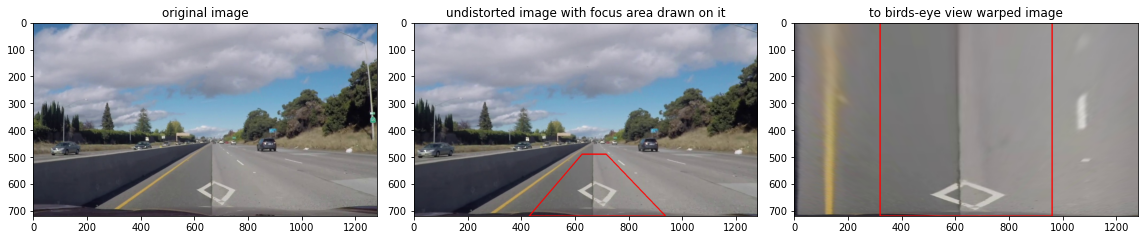

In [26]:
################# STEP 2: Perspective Transform, warp undistorted images to birds-eye-view #################

# Load a straight lane line image
image = mpimg.imread("Images/Frames/image114.jpg")

# Grab the image shape
img_size = (image.shape[1], image.shape[0])

src = np.array([[(img_size[0] / 2 - 15),    (img_size[1] / 2 + 130)],     # left / upper
                [(img_size[0] / 6 - (-215)),     img_size[1]],            # left / lower 
                [(img_size[0] * 5 / 6 + (-130)), img_size[1]],            # right / lower
                [(img_size[0] / 2 + 75),    (img_size[1] / 2 + 130)]], np.float32) # right / upper

dst = np.array([[(img_size[0] / 4),     0],              # left / upper
                [(img_size[0] / 4),     img_size[1]],    # left / lower 
                [(img_size[0] * 3 / 4), img_size[1]],    # right / lower
                [(img_size[0] * 3 / 4), 0]], np.float32) # right / upper

print(f'dst: {dst}')
print(f'src: {src}')

# Load Camera Calibration data
cam_callibration = np.load('camera_cal/camera_cal_parameters.npz') #print(cam_callibration.files)
mtx = cam_callibration['mtx']
dist = cam_callibration['dist']

# Remove distortion
undist = cv2.undistort(image, mtx, dist, None, mtx)

# Calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)

# Warp image
warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
warped_image = np.copy(warped) # copy for visualization of the detected lane line pixels

# Draw lines on images
src_pts = src.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(undist, [src_pts], isClosed=True, color=(255, 0, 0), thickness=3)

dst_pts = dst.astype(np.int32).reshape((-1, 1, 2))
cv2.polylines(warped, [dst_pts], isClosed=True, color=(255, 0, 0), thickness=3)

# Plot images
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,8))
ax1.set_title('original image')
ax1.imshow(image)
ax2.set_title('undistorted image with focus area drawn on it')
ax2.imshow(undist)
ax3.set_title('to birds-eye view warped image')
ax3.imshow(warped)
plt.tight_layout()
#f.savefig(f'examples/perspective_transform.png')

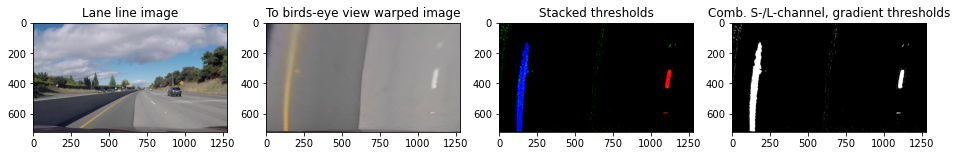

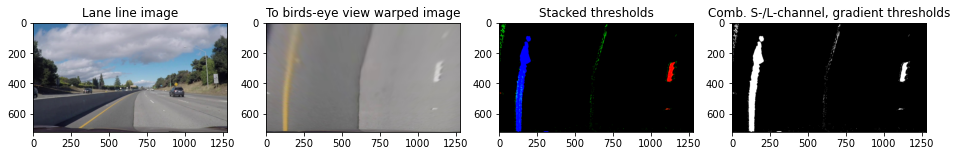

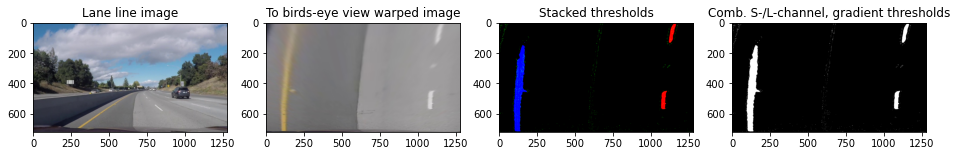

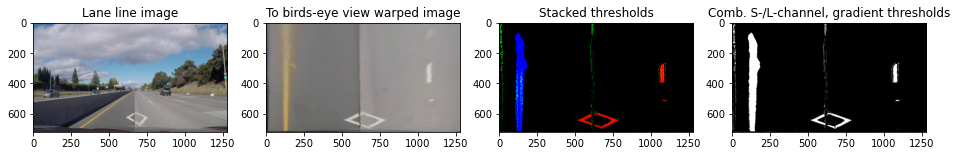

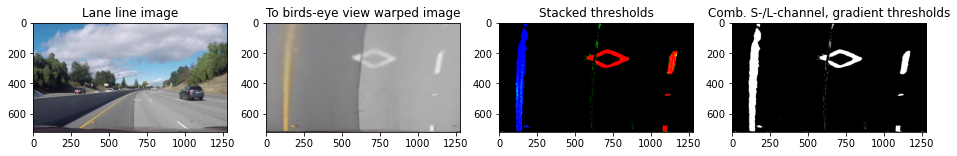

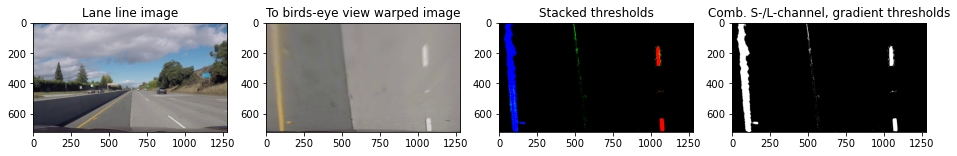

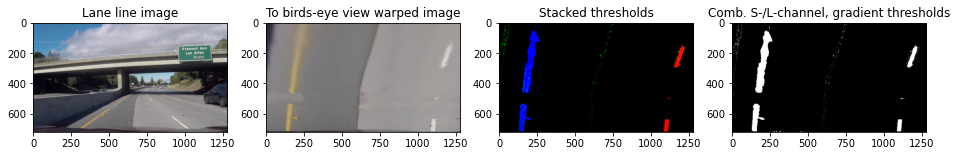

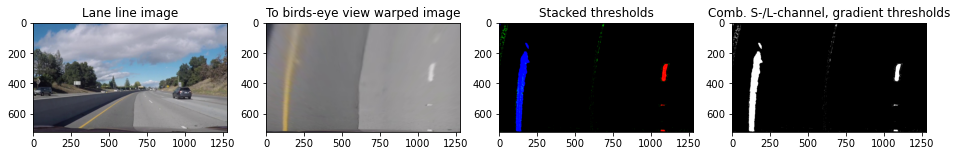

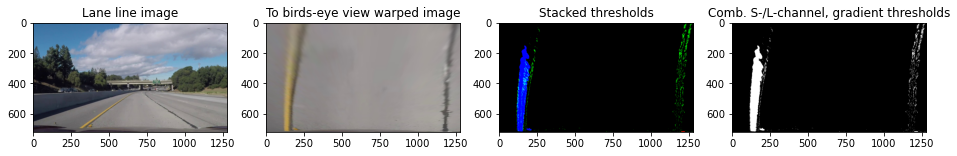

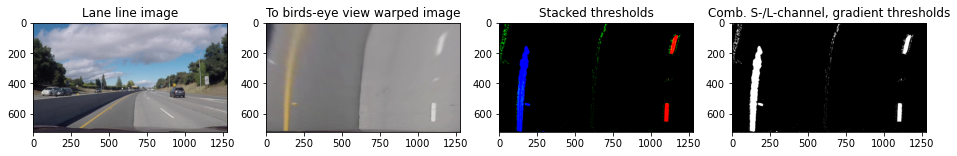

In [27]:
# Load test images and adjust the threshold for the lane line detection:

test_images = glob.glob(r'Images/Frames/*.jpg')

for test_img in test_images[:160:16]:
    # name for saving the plot
    save_name = r'examples/sample_' + test_img.split('/')[1]
    # Load image
    test_img = mpimg.imread(test_img)
    # Warp image
    test_img_warped = warp_image(test_img, mtx, dist, src, dst)
    color_binary, combined_binary = combined_lane_line_detection_challenge(test_img_warped)
    # Plot images
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(16,8))
    ax1.set_title('Lane line image')
    ax1.imshow(test_img)
    ax2.set_title('To birds-eye view warped image')
    ax2.imshow(test_img_warped)
    ax3.set_title('Stacked thresholds')
    ax3.imshow(color_binary)
    ax4.set_title('Comb. S-/L-channel, gradient thresholds')
    ax4.imshow(combined_binary, cmap='gray')
    #f.savefig(save_name)

In [28]:
################# STEP 8: Pipline for the lane line detection #################

## STEP 1: initialisation

# Set source and destination points manually
src = np.array([[(img_size[0] / 2 - 15),    (img_size[1] / 2 + 130)],     # left / upper
                [(img_size[0] / 6 - (-215)),     img_size[1]],            # left / lower 
                [(img_size[0] * 5 / 6 + (-130)), img_size[1]],            # right / lower
                [(img_size[0] / 2 + 75),    (img_size[1] / 2 + 130)]], np.float32) # right / upper


dst = np.array([[(img_size[0] / 4),     0],
                [(img_size[0] / 4),     img_size[1]],
                [(img_size[0] * 3 / 4), img_size[1]],
                [(img_size[0] * 3 / 4), 0]], np.float32)


# Load Camera Calibration data
cam_callibration = np.load('camera_cal/camera_cal_parameters.npz')
mtx = cam_callibration['mtx']
dist = cam_callibration['dist']

# initialize object for the left and the right lane line
left_line  = Line()
right_line = Line()
lines = {}
lines['left_line']  = left_line
lines['right_line'] = right_line

def pipeline_lane_detection_challenge(image):
    

    ## STEP 2: Perspective Transform to birds-eye view
    warped_img = warp_image(image, mtx, dist, src, dst)
    
    ## STEP 3: Combined Color and Gradient Threshold for lane line detection
    _, warped_binary = combined_lane_line_detection_challenge(warped_img)
    
    for key, line in lines.items():
        
        ## STEP 4: Collect pixels from lane line detection
        line.set_image_size(image)
        if line.detected:
            #print('last detection', key)
            line.search_pix_around_last_detection(warped_binary, key)
        else:
            #print('windows', key)
            line.search_pix_with_windows(warped_binary, key)               
            line.set_detected(True)     

        ## STEP 5: Fit polynomials        
        line.fit_polynomial()

        ## STEP 6: Calculate the current radius of the lane line curvature in meters
        line.measure_curvature()

        ## STEP 7: Set distance of vehicle center from the line
        line.set_line_base_pos()

        ## SETP 8: Check position compared to image center
        line.check_offset_from_base_pos()
    
    ## STEP 9: Draw lane lines area onto the road with additional informations
    position = car_position(left_line.best_fit_m, right_line.best_fit_m, image)
    result_image = project_lane_lines_infos(image,
                                            combined_binary,
                                            left_line.current_fit,
                                            right_line.current_fit,
                                            dst, src,
                                            left_line.best_rad_of_curv,
                                            right_line.best_rad_of_curv,
                                            position,
                                            left_line.line_check,
                                            right_line.line_check,
                                            left_line.diffs
                                           )
    
    return result_image

In [29]:
video_output_challenge = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')#.subclip(t_start=0, t_end=6)
output_clip2 = clip2.fl_image(pipeline_lane_detection_challenge) #This function expects color images
%time output_clip2.write_videofile(video_output_challenge, audio=False)


t:   1%|          | 3/485 [00:00<00:29, 16.34it/s, now=None]

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 2min 48s, sys: 11.5 s, total: 3min
Wall time: 1min 6s


In [30]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>'*'
""".format(video_output_challenge))